In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridSpec

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import gym
from gym import spaces

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
from scipy import stats

%matplotlib inline

In [2]:
pd.options.display.max_columns = 40

In [3]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# 1. Data Preprocessing

In [4]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [5]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [6]:
summary = resumetable(data)
summary

data shape: (10000, 15)


,data type,num_NaN,num_unique,data category
CreditScore,int64,0,460,Integer
Geography,object,0,3,Categorical
Gender,object,0,2,Categorical
Age,int64,0,70,Integer
Tenure,int64,0,11,Integer
Balance,float64,0,6382,Numeric
NumOfProducts,int64,0,4,Integer
HasCrCard,int64,0,2,Integer
IsActiveMember,int64,0,2,Integer
EstimatedSalary,float64,0,9999,Numeric


We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

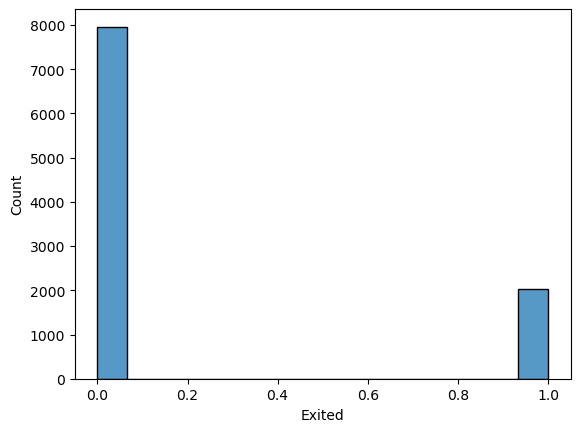

In [7]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [8]:
zero = data[data['Balance'] == 0]

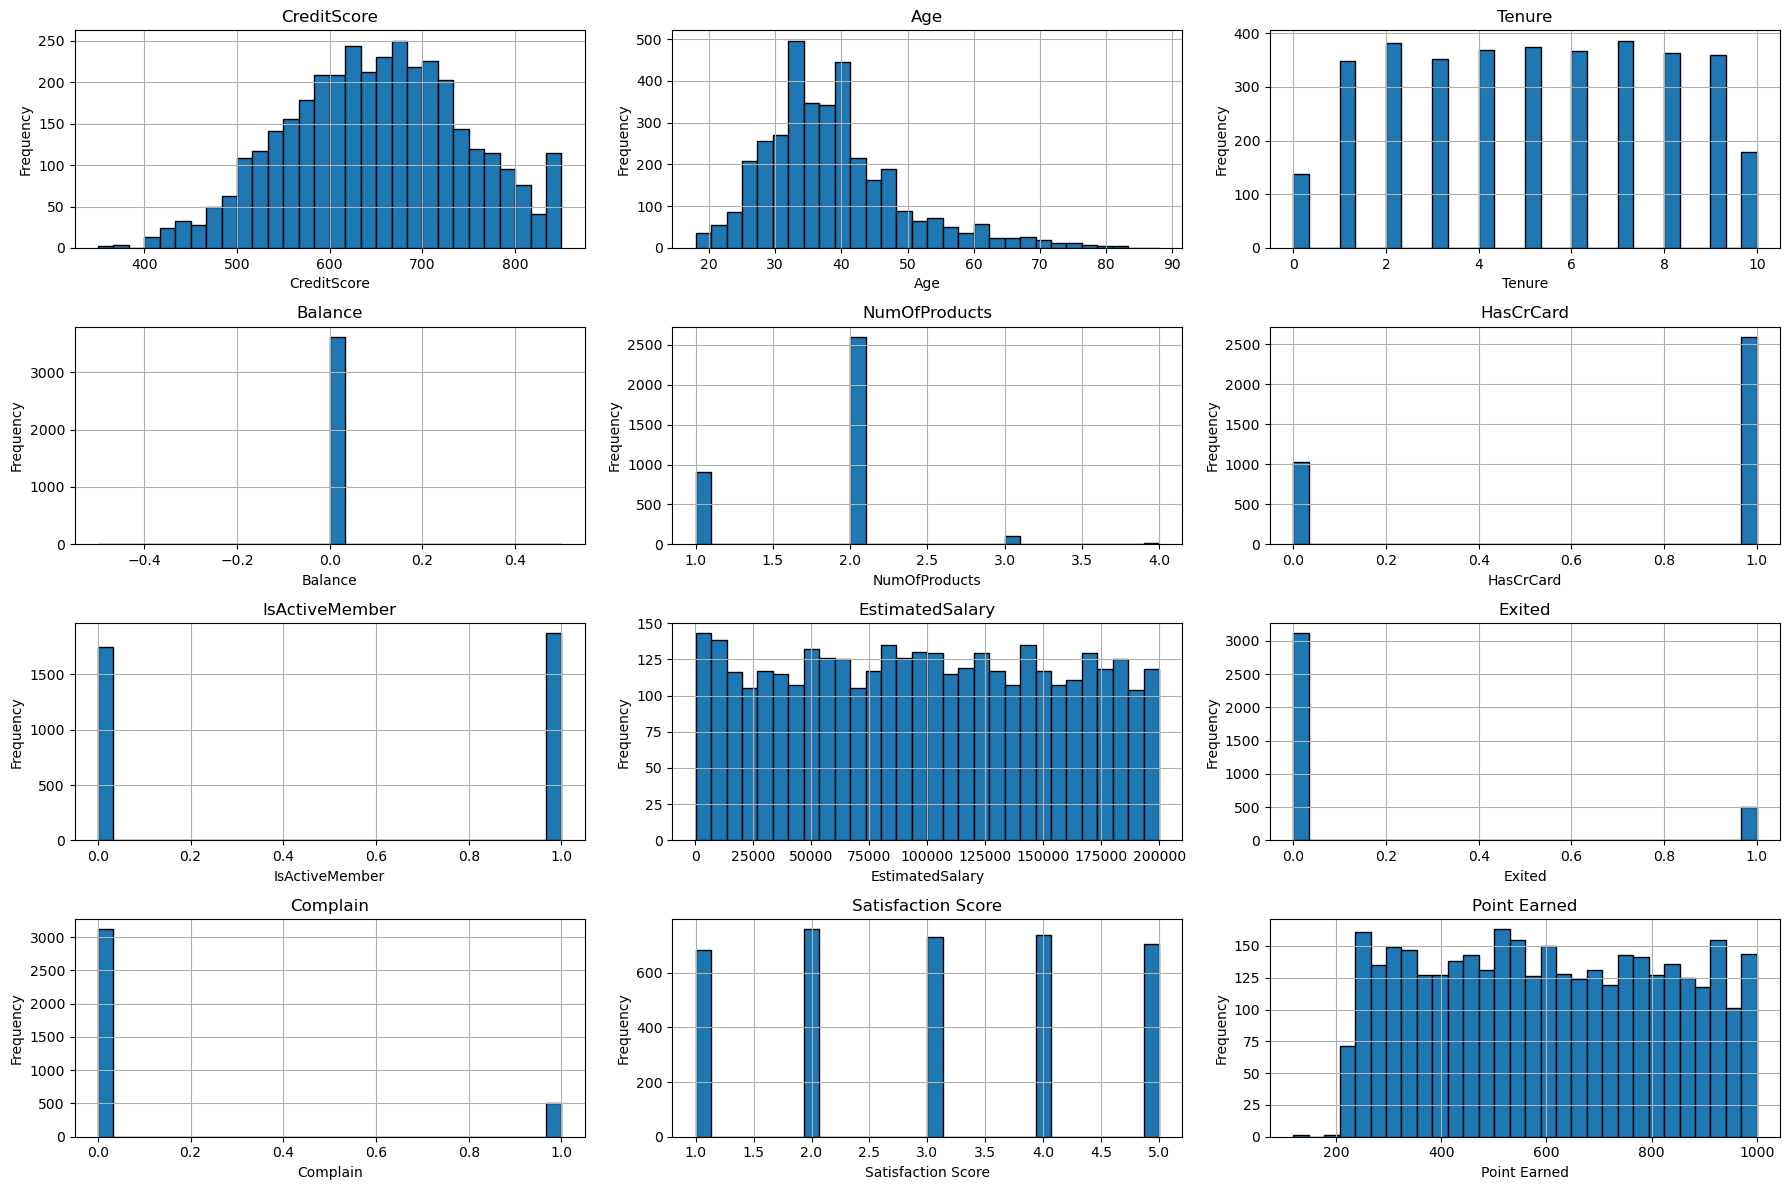

In [9]:
numeric_columns = zero.select_dtypes(include=['float64', 'int64']).columns

# Re-plot using subplots with a larger figure to avoid scrolling
plt.figure(figsize=(18, 12))  # Larger figure to fit all plots
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid size to fit all features
    zero[column].hist(bins=30, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
round(data.describe(), 2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.0,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2,0.2,3.01,606.52
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4,0.4,1.41,225.92
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0,0.0,1.00,119.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0,0.0,2.00,410.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0,0.0,3.00,605.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0,0.0,4.00,801.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.0,5.00,1000.00


We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [11]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

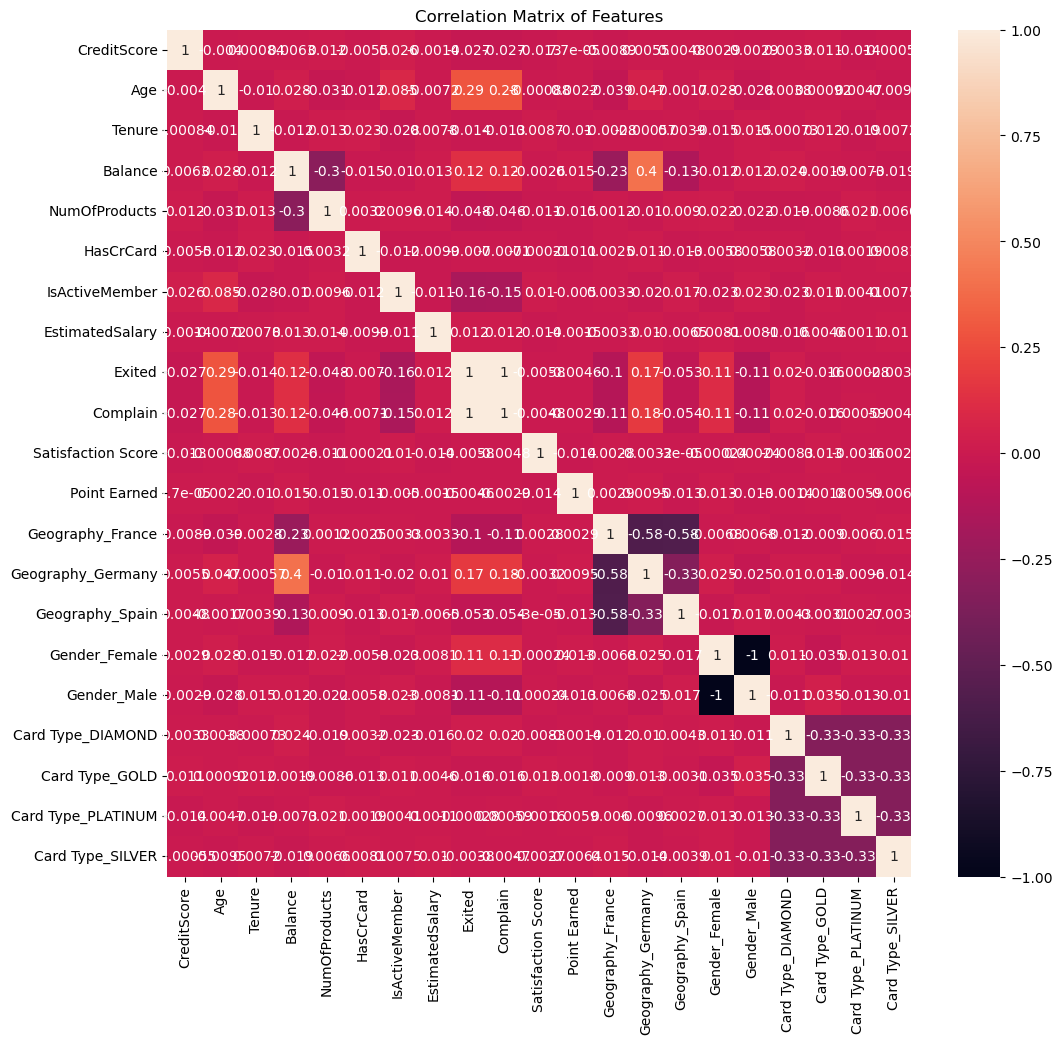

In [12]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

### Data Scaling (pending at this point)

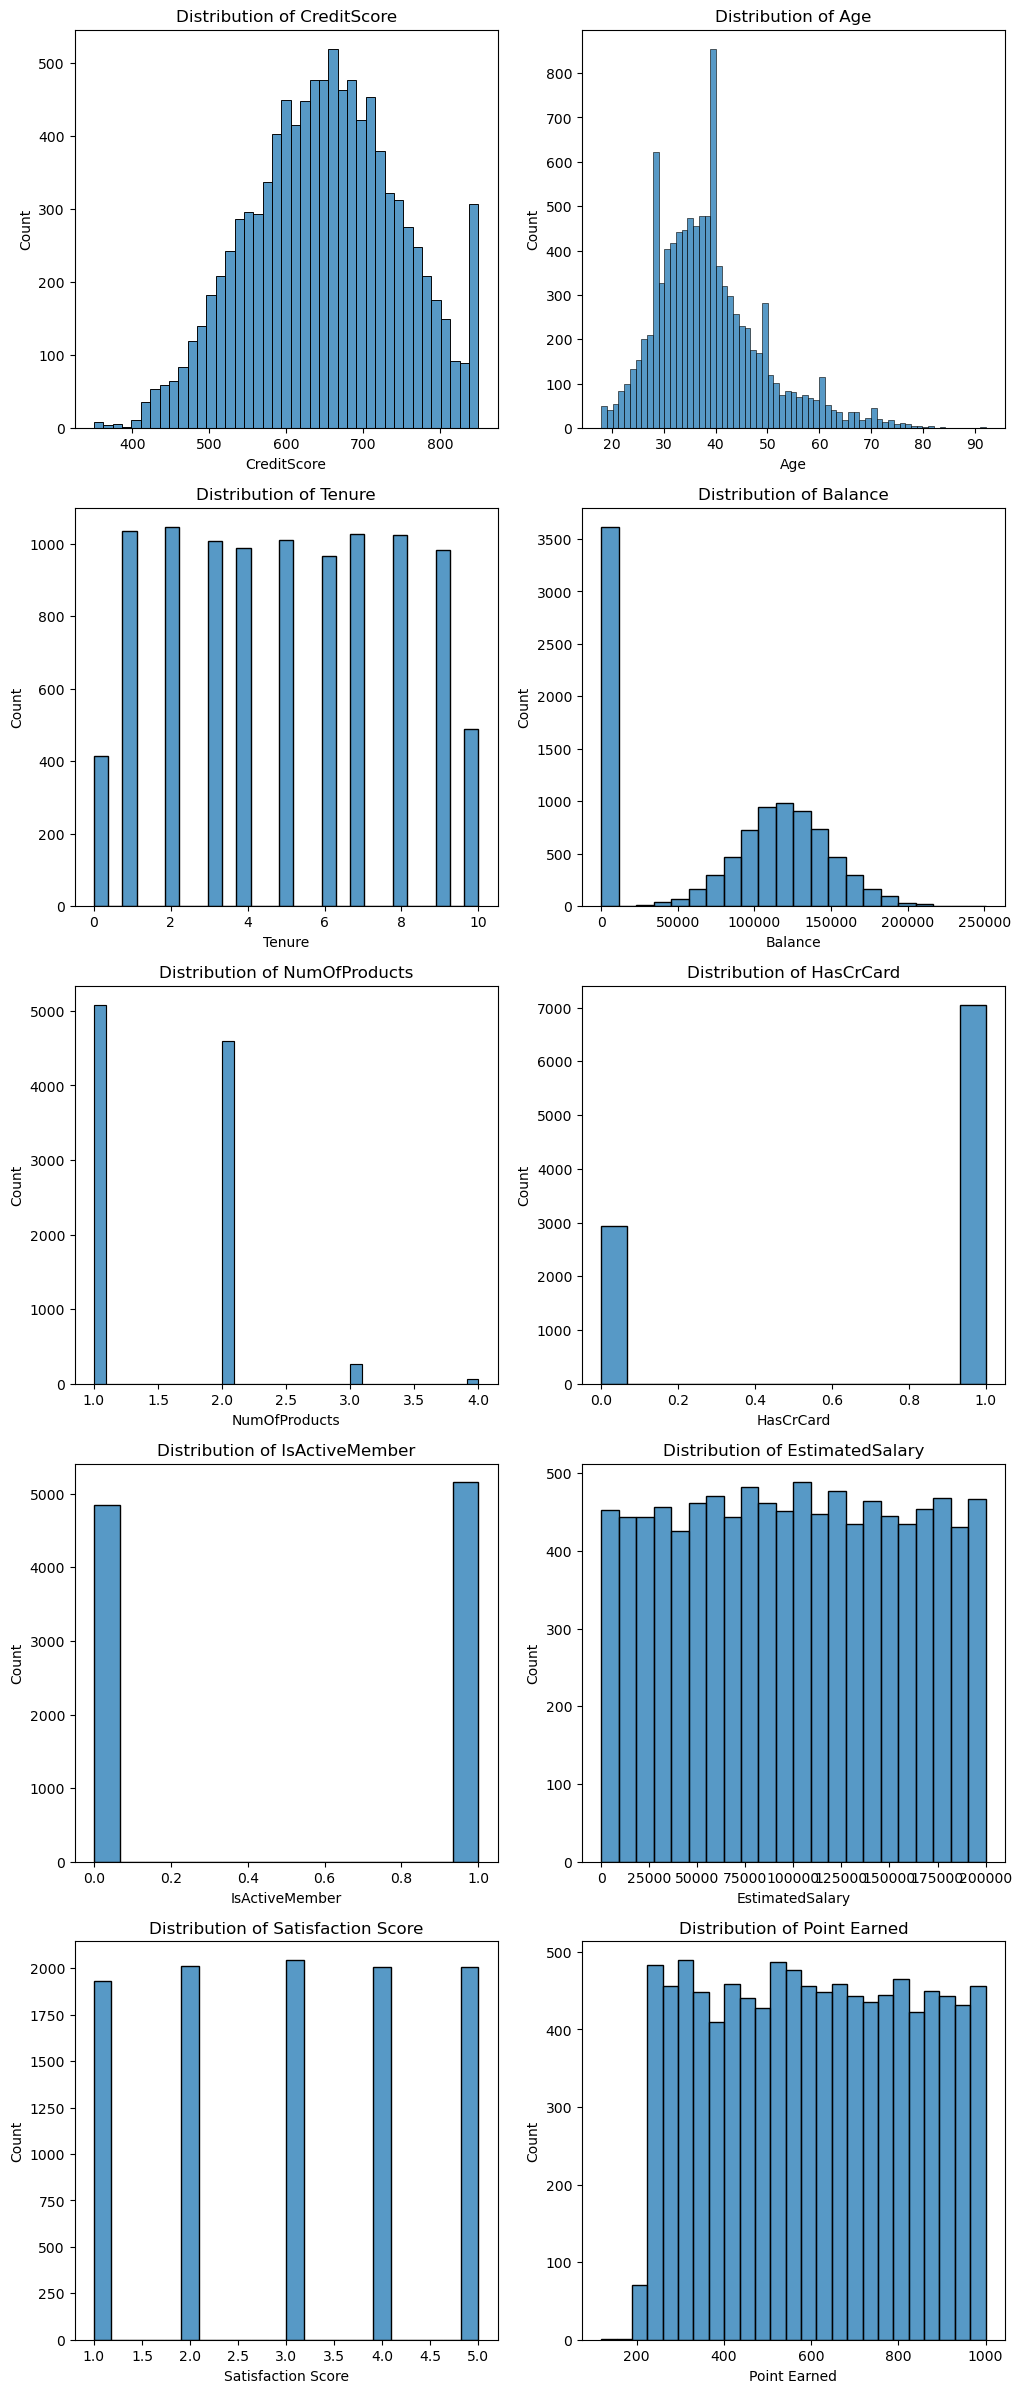

In [13]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

In [14]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

In [15]:
# standard_scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
# data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
# data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [16]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


### Feature Engineering

In [17]:
# data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [18]:
# bins = [0, 2, 4, 6, 8, 10]
# labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
# data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
# data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

### Feature importance by random forest

In [19]:
# data.drop(['Complain'], axis = 1, inplace = True) # 보류

In [20]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [21]:
bins = [300, 580, 670, 740, 800, 851]
labels = ['Poor credit: 300-579', 'Fair credit: 580-669', 'Good credit: 670-739', 'Very good credit: 740-799', 'Excellent credit: 800-850']

a = pd.cut(data['CreditScore'], bins=bins)
a.value_counts()

exited_data = data[data['Exited'] == 1].copy()
exited_data['CreditScore_Binned'] = pd.cut(exited_data['CreditScore'], bins=bins, labels=labels, right=False)
credit_score_distribution = exited_data['CreditScore_Binned'].value_counts().sort_index()
print(a.value_counts())
print(credit_score_distribution)

CreditScore
(580, 670]    3350
(670, 740]    2397
(300, 580]    2393
(740, 800]    1215
(800, 851]     645
Name: count, dtype: int64
CreditScore_Binned
Poor credit: 300-579         520
Fair credit: 580-669         685
Good credit: 670-739         452
Very good credit: 740-799    253
Excellent credit: 800-850    128
Name: count, dtype: int64


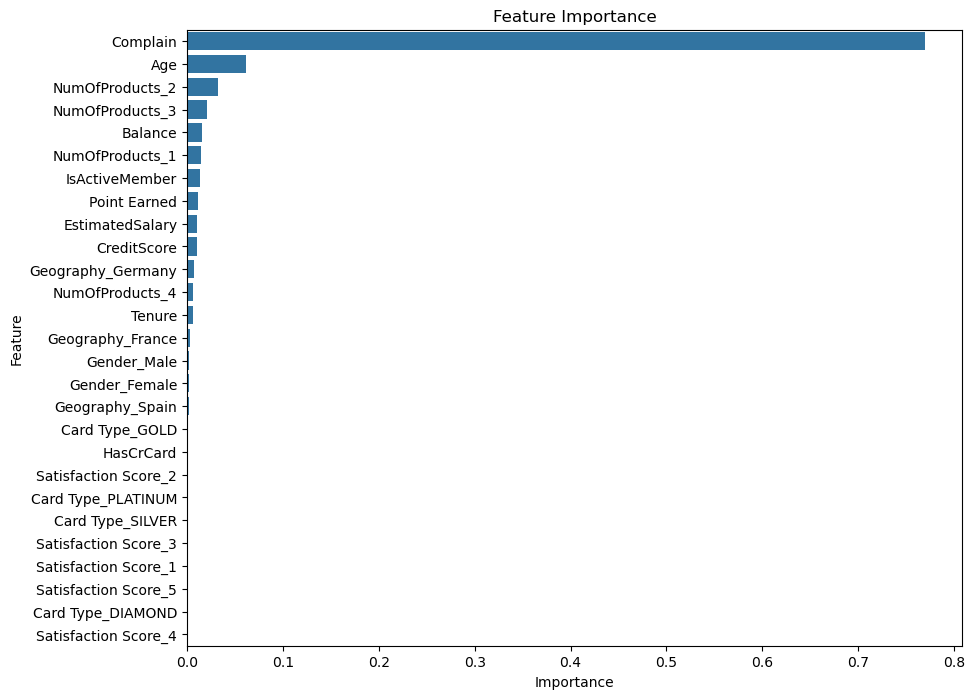

In [22]:
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')
plt.title('Feature Importance')
plt.show();

# 2. Exploratory Data Analysis

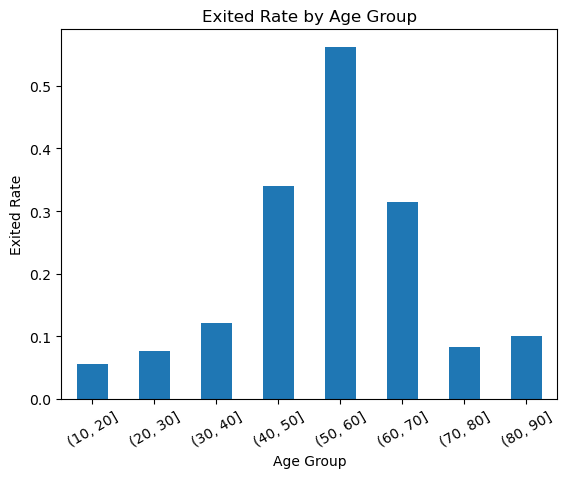

In [23]:
# Age vs Exited
age_groups = pd.cut(data['Age'], bins=range(0, 100, 10))
age_exit_ratio = data.groupby(age_groups, observed=True)['Exited'].mean()

age_exit_ratio.plot(kind = 'bar')
plt.xlabel('Age Group')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Age Group')
plt.xticks(rotation = 30);

In [36]:
age_exit_ratio

Age
(10, 20]    0.056180
(20, 30]    0.076104
(30, 40]    0.121096
(40, 50]    0.339655
(50, 60]    0.562108
(60, 70]    0.314199
(70, 80]    0.082645
(80, 90]    0.100000
Name: Exited, dtype: float64

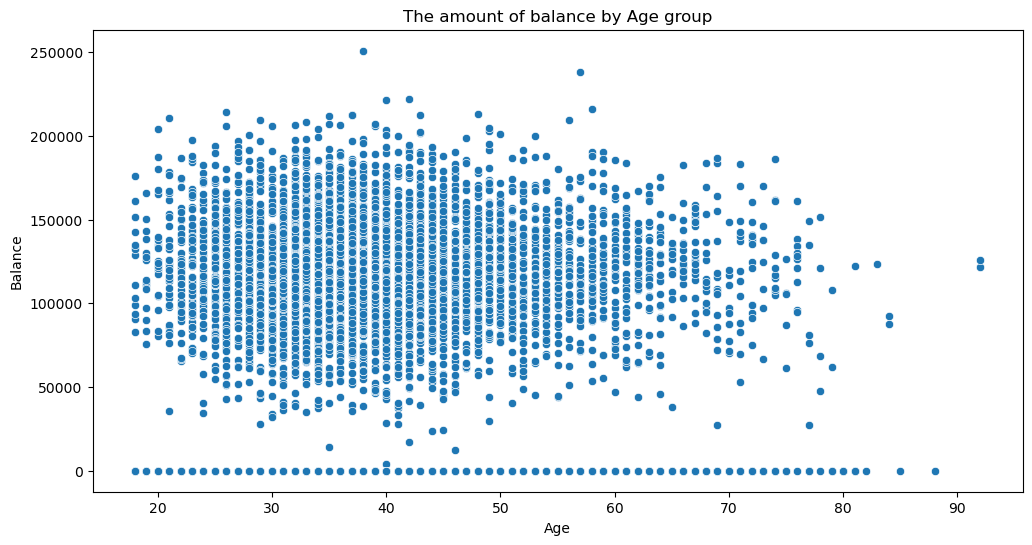

In [24]:
data[['Age', 'Balance']].sort_values(by = 'Age')

plt.figure(figsize = (12, 6))
sns.scatterplot(data, x = 'Age', y = 'Balance')
plt.title("The amount of balance by Age group");

We can perform hypothesis testing here.

Let's suppose the null hypothesis is that as age increases, the balance amount does not change. Then, the alternative hypothesis is that as age increases, the balance increases. We’ll conduct a right-tailed, one-sided test to evaluate this relationship.

One way to test this hypothesis is by examining the correlation between age and balance:

Null Hypothesis ($H_0$): There is no correlation between age and balance.

Alternative Hypothesis ($H_1$): There is a positive correlation between age and balance (i.e., as age increases, balance also increases).


This test will allow us to directly test if balance tends to increase as age increases.

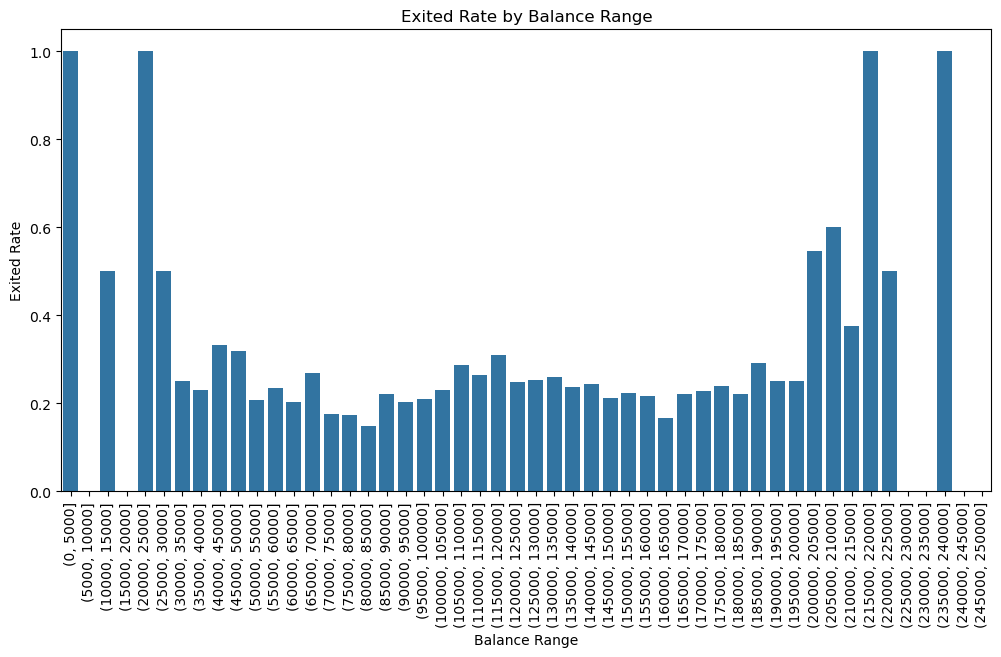

In [25]:
balance_bins = pd.cut(data['Balance'], bins=range(0, 251000, 5000))
balance_exit_ratio = data.groupby(balance_bins, observed= True)['Exited'].mean()

plt.figure(figsize = (12, 6))
sns.barplot(data = balance_exit_ratio)
plt.xlabel('Balance Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance Range')
plt.xticks(rotation = 90);

In [51]:
balance_exit_ratio

Balance
(0, 5000]           1.000000
(10000, 15000]      0.500000
(15000, 20000]      0.000000
(20000, 25000]      1.000000
(25000, 30000]      0.500000
(30000, 35000]      0.250000
(35000, 40000]      0.230769
(40000, 45000]      0.333333
(45000, 50000]      0.320000
(50000, 55000]      0.206897
(55000, 60000]      0.235294
(60000, 65000]      0.202703
(65000, 70000]      0.268293
(70000, 75000]      0.176991
(75000, 80000]      0.173913
(80000, 85000]      0.148515
(85000, 90000]      0.222222
(90000, 95000]      0.202429
(95000, 100000]     0.210227
(100000, 105000]    0.231405
(105000, 110000]    0.288416
(110000, 115000]    0.265356
(115000, 120000]    0.310588
(120000, 125000]    0.248889
(125000, 130000]    0.252232
(130000, 135000]    0.260638
(135000, 140000]    0.237430
(140000, 145000]    0.244224
(145000, 150000]    0.212996
(150000, 155000]    0.222707
(155000, 160000]    0.216561
(160000, 165000]    0.167883
(165000, 170000]    0.220472
(170000, 175000]    0.227273
(17500

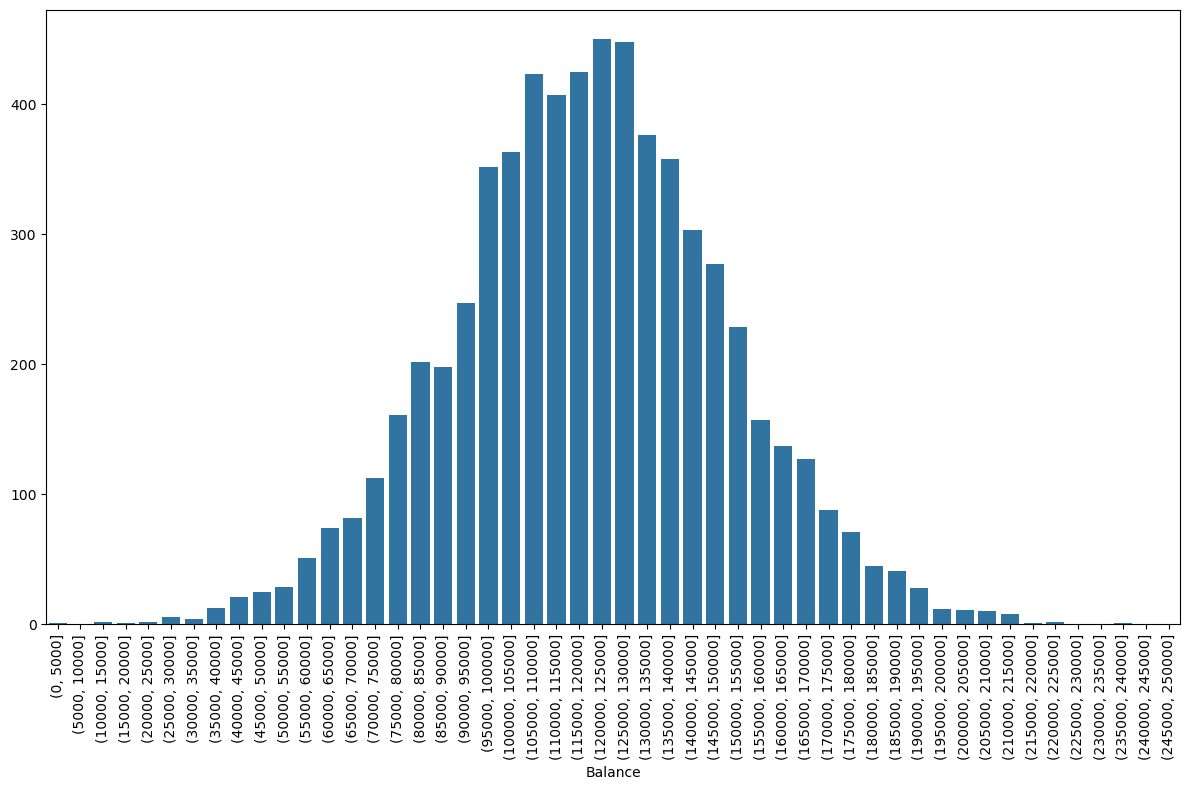

In [49]:
balance_bins_counts = balance_bins.value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=balance_bins_counts.index.astype(str), y=balance_bins_counts.values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
balance_bins_counts

Balance
(0, 5000]             1
(5000, 10000]         0
(10000, 15000]        2
(15000, 20000]        1
(20000, 25000]        2
(25000, 30000]        6
(30000, 35000]        4
(35000, 40000]       13
(40000, 45000]       21
(45000, 50000]       25
(50000, 55000]       29
(55000, 60000]       51
(60000, 65000]       74
(65000, 70000]       82
(70000, 75000]      113
(75000, 80000]      161
(80000, 85000]      202
(85000, 90000]      198
(90000, 95000]      247
(95000, 100000]     352
(100000, 105000]    363
(105000, 110000]    423
(110000, 115000]    407
(115000, 120000]    425
(120000, 125000]    450
(125000, 130000]    448
(130000, 135000]    376
(135000, 140000]    358
(140000, 145000]    303
(145000, 150000]    277
(150000, 155000]    229
(155000, 160000]    157
(160000, 165000]    137
(165000, 170000]    127
(170000, 175000]     88
(175000, 180000]     71
(180000, 185000]     45
(185000, 190000]     41
(190000, 195000]     28
(195000, 200000]     12
(200000, 205000]     11
(205000,

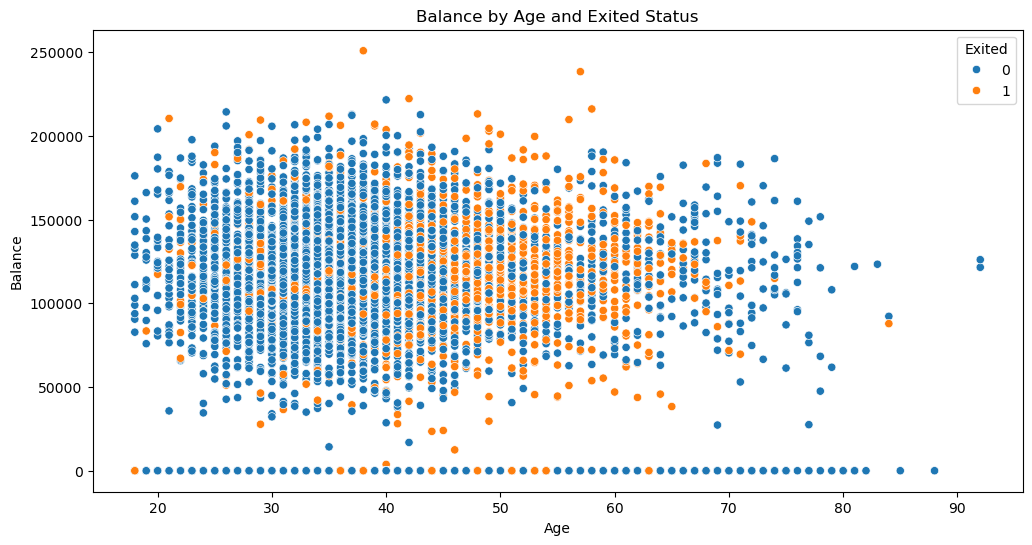

In [38]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Age', y='Balance', hue='Exited', data=data)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Balance by Age and Exited Status')
plt.show()

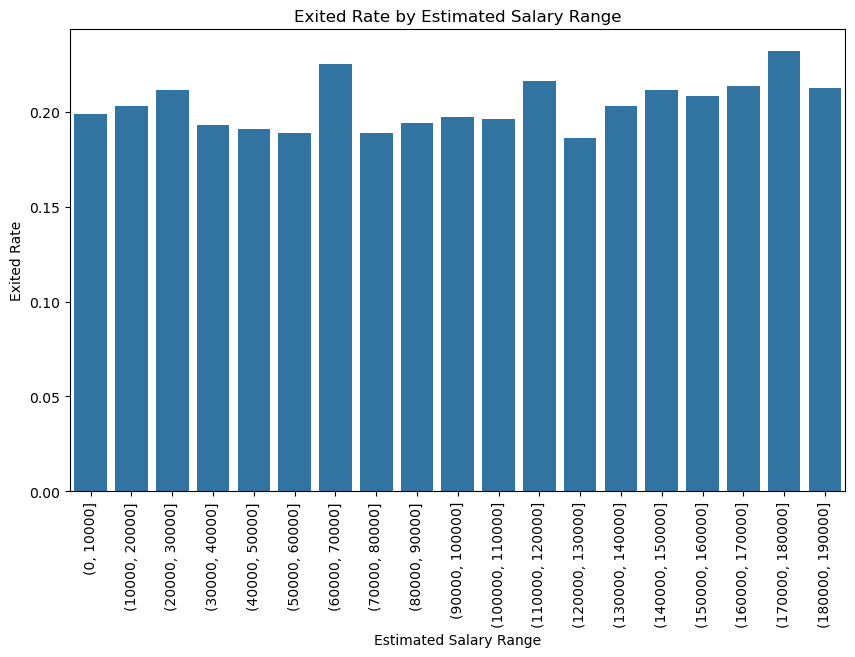

In [26]:
# Estimated Salary VS Exited
salary_bins = pd.cut(data['EstimatedSalary'], bins=range(0, 200000, 10000))
salary_exit_ratio = data.groupby(salary_bins, observed=False)['Exited'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(data = salary_exit_ratio)
plt.xlabel('Estimated Salary Range')
plt.ylabel('Exited Rate')
plt.xticks(rotation = 90)
plt.title('Exited Rate by Estimated Salary Range');

{'Card Type_DIAMOND': 0.2177901874750698, 'Card Type_GOLD': 0.1926458832933653, 'Card Type_PLATINUM': 0.2036072144288577, 'Card Type_SILVER': 0.20112179487179488}


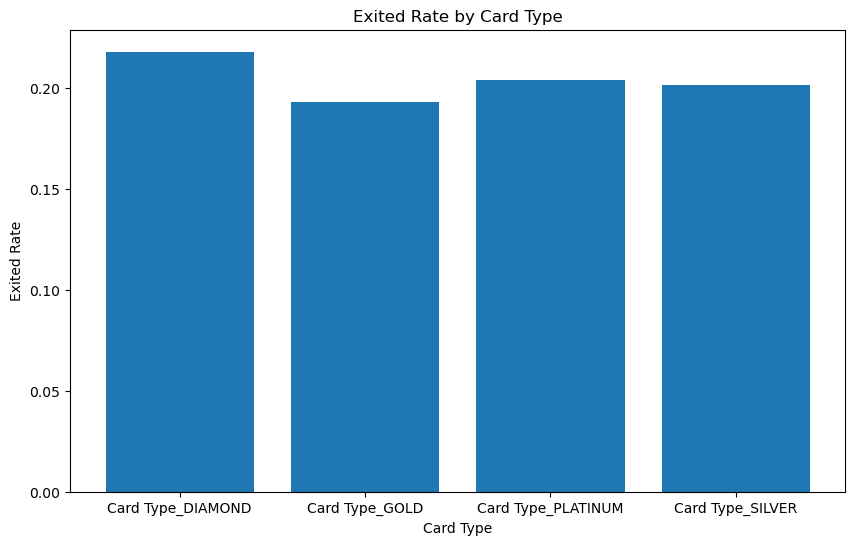

In [27]:
# Card Type VS Exited
card_types = ['Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']
card_exit_ratios = {}

for card_type in card_types:
    card_exit_ratios[card_type] = data.loc[data[card_type] == 1, 'Exited'].mean()

card_exit_df = pd.DataFrame(list(card_exit_ratios.items()), columns=['Card Type', 'Exited Rate'])

plt.figure(figsize = (10, 6))
plt.bar(card_exit_df['Card Type'], card_exit_df['Exited Rate'])
plt.xlabel('Card Type')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Card Type');

print(card_exit_ratios)

Point Earned
(100, 150]    0.000000
(150, 200]    1.000000
(200, 250]    0.198135
(250, 300]    0.227618
(300, 350]    0.201767
(350, 400]    0.209184
(400, 450]    0.204800
(450, 500]    0.174267
(500, 550]    0.190131
(550, 600]    0.205749
(600, 650]    0.194099
(650, 700]    0.222222
(700, 750]    0.218299
(750, 800]    0.219512
(800, 850]    0.237261
(850, 900]    0.170732
(900, 950]    0.180428
Name: Exited, dtype: float64


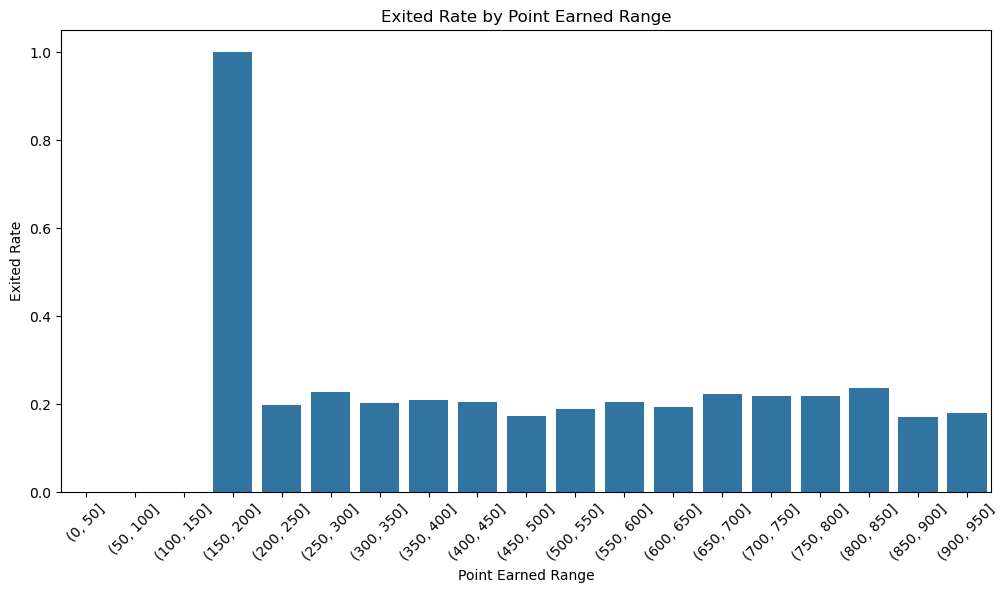

In [28]:
# Point Earned VS Exited
point_bins = pd.cut(data['Point Earned'], bins=range(0, 1000, 50))
point_exit_ratio = data.groupby(point_bins, observed = True)['Exited'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(point_exit_ratio)
plt.xlabel('Point Earned Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Point Earned Range')
plt.xticks(rotation=45);

print(point_exit_ratio)

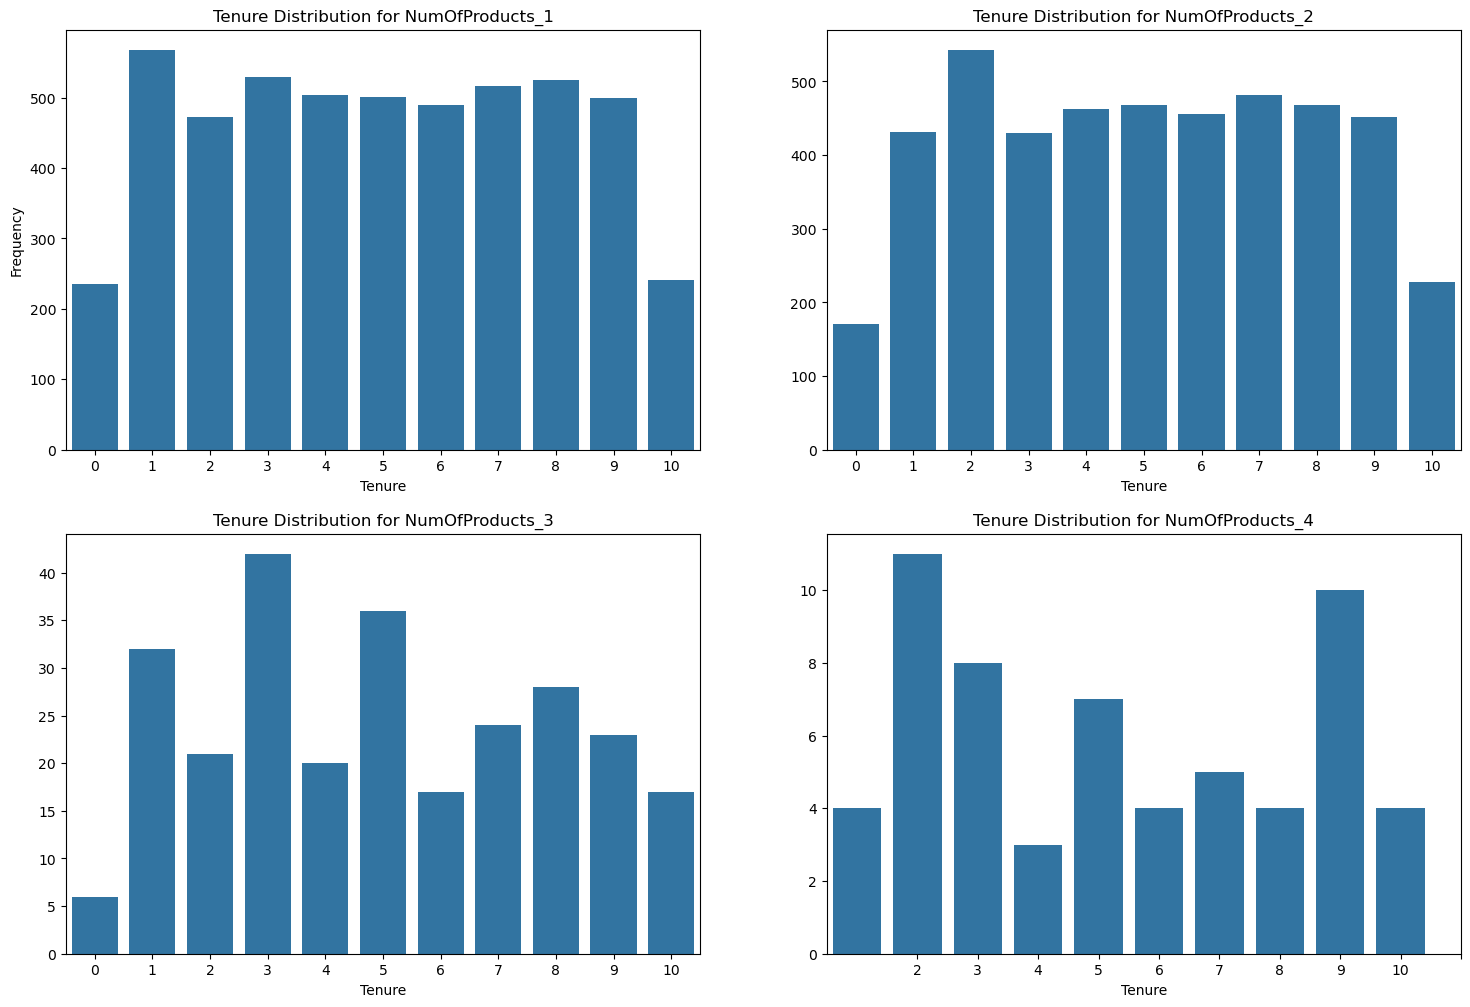

In [29]:
num_products = [f'NumOfProducts_{i}' for i in range(1, 5)]

fig, axes = plt.subplots(2, 2, figsize = (18, 12))
axes = axes.flatten()

for i, col in enumerate(num_products):
    subset = data[data[col] == 1]
    tenure_counts = subset['Tenure'].value_counts().sort_index()
    sns.barplot(x = tenure_counts.index, y = tenure_counts.values, ax = axes[i])
    
    axes[i].set_title(f'Tenure Distribution for {col}')
    axes[i].set_xlabel('Tenure')
    if i == 0:
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_ylabel('')
    
    axes[i].set_xticks(tenure_counts.index)
    axes[i].tick_params(axis='x')

plt.show()

Balance
False    0.240953
True     0.138236
Name: Exited, dtype: float64


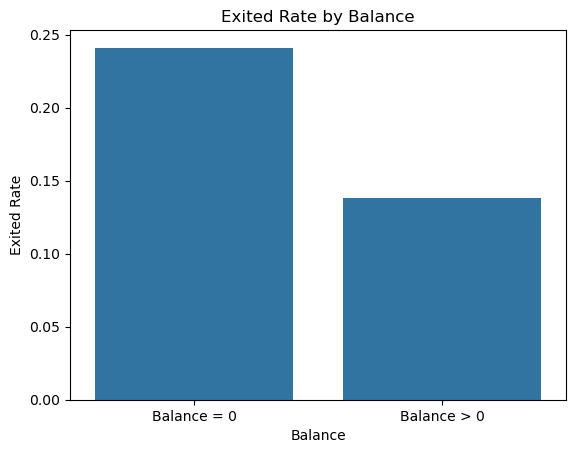

In [30]:
balance_exit_rate = data.groupby(data['Balance'] == 0)['Exited'].mean()

sns.barplot(balance_exit_rate)
plt.xticks([0, 1], ['Balance = 0', 'Balance > 0'], rotation=0)
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance');

print(balance_exit_rate)

Complain
0    0.000503
1    0.995108
Name: Exited, dtype: float64


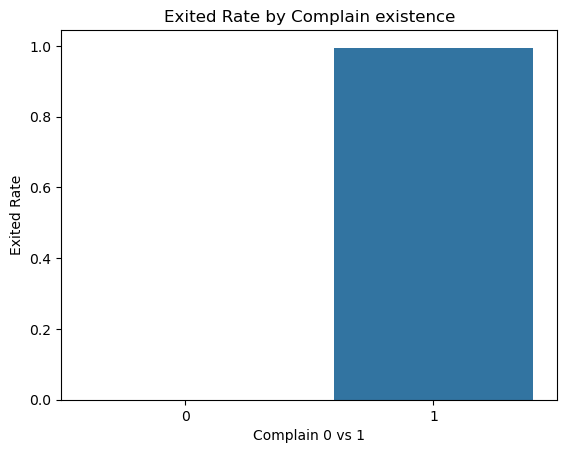

In [31]:
# Complain VS Exited
complain_exit_ratio = data.groupby('Complain')['Exited'].mean()

sns.barplot(complain_exit_ratio)
plt.xlabel("Complain 0 vs 1")
plt.ylabel("Exited Rate")
plt.title("Exited Rate by Complain existence");

print(complain_exit_ratio)

# 3. Reinforcement Learning Environment Setup

In [52]:
class ChurnEnvironment(gym.Env):
    def __init__(self, data):
        super(ChurnEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        
        self.state_features = [
            'CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Complain', 'Point Earned',
            'Geography_1', 'Geography_2', 'Geography_3', 'Gender_Female',
            'Gender_Male', 'Card Type_DIAMOND', 'Card Type_GOLD',
            'Card Type_PLATINUM', 'Card Type_SILVER', 'NumOfProducts_1',
            'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
            'Satisfaction Score_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
            'Satisfaction Score_4', 'Satisfaction Score_5']
        
        # Define state space as a continuous vector
        self.state_space = spaces.Box(low=0, 
                                      high=np.inf, 
                                      shape=(len(self.state_features),), 
                                      dtype=np.float32)
        

        self.action_space = spaces.Discrete(5)
        self.actions = {
            0: "Personalized Interest Rate Adjustment",
            1: "Customized Product Bundling",
            2: "Age-based Promotion",
            3: "Customized Product Bundle",
            4: "Immediate Personalized Resolution"}
        
    def reset(self):
        """
        Select random customer data as initial state at the start of each episode
        """
        self.current_step = np.random.randint(0, len(self.data))
        return self._get_state()
    
    def _get_state(self):
        """
        Return the current state vector
        """
        state = self.data.loc[self.current_step, self.state_features].values
        return state.astype(np.float32)

    def calculate_reward(self, customer, action):
        reward = 0
        
        # 0. Personalized Interest Rate Adjustment 
        if action == 0: 
            if customer['CreditScore'] < 579:
                reward += 1.0
            elif 580 <= customer['CreditScore'] <= 669:
                reward += 1.2
            elif 670 <= customer['CreditScore'] <= 739:
                reward += 1.0
            elif 740 <= customer['CreditScore'] <= 799:
                reward += 0.7
            else:
                reward += 0

        # 1. Financial Planning Assistance 
        elif action == 2:
            if customer['Balance'] >= 200000:
                reward -= 0.7

        # 2. Age-based Promotion 
        elif action == 3:
            if customer['Age'] < 40:
                reward += 0.5  
            elif 40 <= customer['Age'] < 50:
                reward -= 0.5  
            elif 50 <= customer['Age'] < 60:
                reward -= 1.0 
            elif 60 <= customer['Age'] < 70:
                reward -= 0.5 
            else:
                reward += 0.5  

        # 3. Customized Product Bundle 
        elif action == 4:  
            if customer['NumOfProducts_1'] == 1:
                reward += 0.8  
            elif customer['NumOfProducts_2'] == 1:
                reward += 1.2  
            elif customer['NumOfProducts_3'] == 1:
                reward -= 0.5  
            elif customer['NumOfProducts_4'] == 1:
                reward -= 1.0 

        # 4. Immediate Personalized Resolution 
        elif action == 5:
            if customer['Complain'] == 0:
                reward += 0.3
            else:
                reward -= 2.0
                
        if customer['Exited'] == 0:
            reward += 1.0  # Reward if customer is retained
        else:
            reward -= 1.0  # Penalty if customer has exited
        return reward

    def step(self, action):
        customer = self.data.iloc[self.current_step]
        reward = self.calculate_reward(customer, action) 
        self.current_step += 1
        done = self.current_step >= len(self.data)
        next_state = self._get_state() if not done else np.zeros(self.state_space.shape)
        return next_state, reward, done, {}